# 타이타닉 생존 분석 프로젝트

타이타닉 사고에서 생존 여부에 영향을 미친 주요 요인들을 분석하고, 로지스틱 회귀 모델을 통해 생존 여부를 예측하는 모델을 구축합니다. 주요 과정은 다음과 같습니다.

1. **데이터 전처리**
2. **탐색적 데이터 분석 (EDA)**
3. **통계적 검정**
4. **머신러닝 모델링**
5. **결론 및 인사이트 도출**

## 1. 데이터 전처리

1. **결측치 처리**: 'Age', 'Fare', 'Embarked' 변수의 결측치를 처리합니다.
2. **이상치 제거**: 'Parch'가 5 이하이고, 'Fare'가 300 이하인 값을 남깁니다.
3. **변수 변환**: 성별을 숫자로 변환하고, 'Embarked' 컬럼에 대해 원-핫 인코딩을 적용하여 머신러닝 모델에 적합한 형태로 변환합니다.
4. **데이터 분리 및 불균형 처리**: 종속변수 'Survived'와 독립변수 'Pclass', 'Sex', 'Age' 등을 사용하여 독립변수(train_x)와 종속변수(train_y)로 나누고, SMOTE를 사용해 데이터 불균형을 해결합니다.


In [32]:
# 라이브러리 불러오기
import pandas as pd
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import numpy as np

# 데이터 로드
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
submission = pd.read_csv('gender_submission.csv')

# 주요 컬럼 선택
columns = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']
train = train[columns + ['Survived']]
test = test[columns]

# 결측치 처리
train['Age'].fillna(train['Age'].mean(), inplace=True)
test['Age'].fillna(test['Age'].mean(), inplace=True)
train['Fare'].fillna(train['Fare'].mean(), inplace=True)
test['Fare'].fillna(test['Fare'].mean(), inplace=True)
train['Embarked'].fillna(train['Embarked'].mode()[0], inplace=True)
test['Embarked'].fillna(test['Embarked'].mode()[0], inplace=True)

# 이상치 제거
train = train[(train['Parch'] <= 5) & (train['Fare'] <= 300)]

# 성별 컬럼 변환
train['Sex'] = train['Sex'].apply(lambda x: 0 if x == 'female' else 1)
test['Sex'] = test['Sex'].apply(lambda x: 0 if x == 'female' else 1)

# One-hot 인코딩 적용
train = pd.get_dummies(train, columns=['Embarked'], drop_first=True)
test = pd.get_dummies(test, columns=['Embarked'], drop_first=True)

# 독립변수와 종속변수로 분리
train_x = train.drop(columns='Survived')
train_y = train['Survived']

# 데이터 분할
train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, test_size=0.2, random_state=0)

# SMOTE로 데이터 불균형 해결 (train 데이터만 적용)
smote = SMOTE(random_state=0)
train_x_resampled, train_y_resampled = smote.fit_resample(train_x, train_y)


/var/folders/ht/4qty58ms4gvf8kvp_td2gn2r0000gn/T/ipykernel_27870/3912651591.py:18: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train['Age'].fillna(train['Age'].mean(), inplace=True)
/var/folders/ht/4qty58ms4gvf8kvp_td2gn2r0000gn/T/ipykernel_27870/3912651591.py:19: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting val

## 2. 탐색적 데이터 분석 (EDA)
- 각 변수가 생존 여부에 미치는 영향을 시각화하고 통계적으로 검증합니다.
- 단일 및 다중 변수 분석을 통해 데이터의 주요 특징을 파악하고 인사이트를 도출합니다.


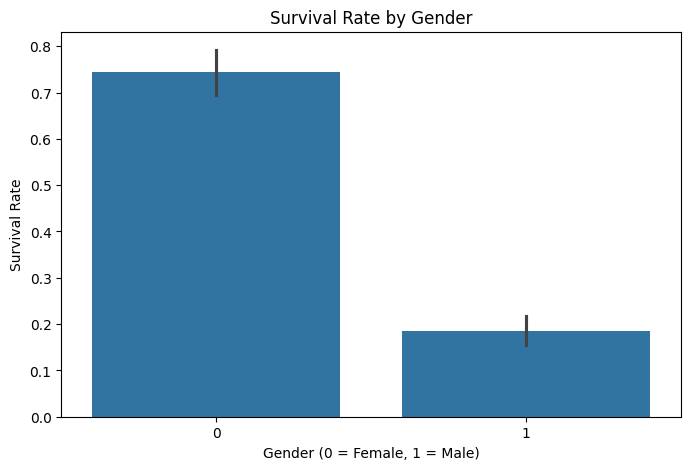

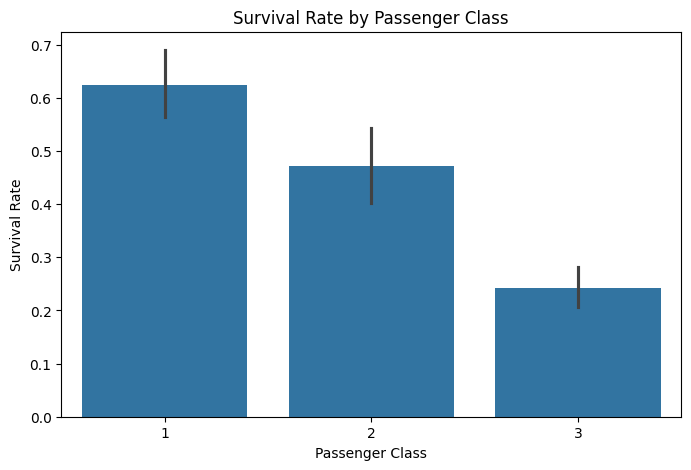

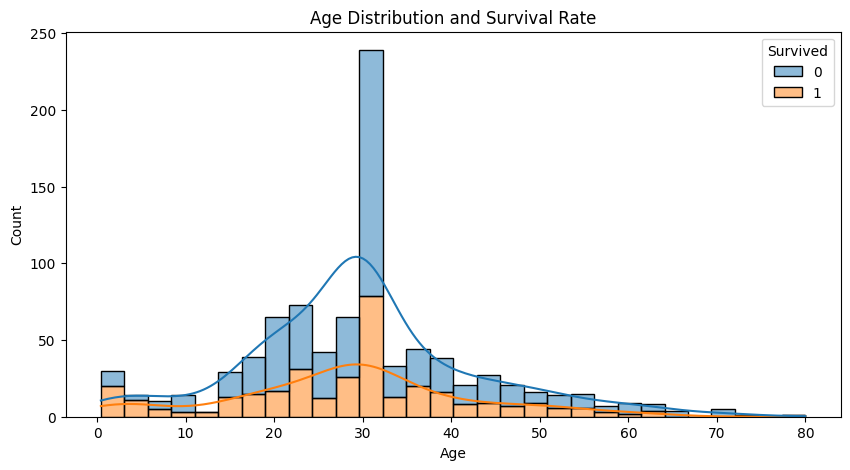

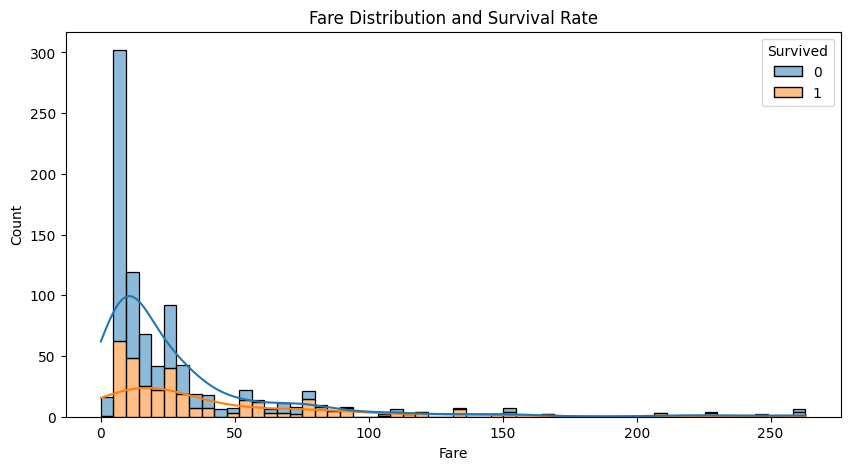

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

# 성별에 따른 생존율 시각화
plt.figure(figsize=(8, 5))
sns.barplot(x='Sex', y='Survived', data=train)
plt.title('Survival Rate by Gender')
plt.xlabel('Gender (0 = Female, 1 = Male)')
plt.ylabel('Survival Rate')
plt.show()

# 객실 등급에 따른 생존율 시각화
plt.figure(figsize=(8, 5))
sns.barplot(x='Pclass', y='Survived', data=train)
plt.title('Survival Rate by Passenger Class')
plt.xlabel('Passenger Class')
plt.ylabel('Survival Rate')
plt.show()

# 나이에 따른 생존율 분포 시각화
plt.figure(figsize=(10, 5))
sns.histplot(data=train, x='Age', hue='Survived', kde=True, multiple='stack')
plt.title('Age Distribution and Survival Rate')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

# 요금(Fare) 분포에 따른 생존율 시각화
plt.figure(figsize=(10, 5))
sns.histplot(data=train, x='Fare', hue='Survived', kde=True, multiple='stack')
plt.title('Fare Distribution and Survival Rate')
plt.xlabel('Fare')
plt.ylabel('Count')
plt.show()


### 단일 변수 분석 결과
1. **성별**: 여성의 생존율이 남성보다 훨씬 높으며, 이는 타이타닉 사고 당시 여성 우선 구조가 이루어졌음을 시사합니다.
2. **객실 등급**: 1등석 승객의 생존율이 가장 높고, 3등석 승객이 가장 낮습니다. 이는 사회적 계층에 따라 구조 우선순위가 달라졌음을 나타냅니다.
3. **나이**: 어린 승객의 생존율이 높으며, 특히 10세 이하의 승객들이 높은 생존율을 보입니다.
4. **요금(Fare)**: 요금이 높을수록 생존율이 높아지는 경향이 있으며, 이는 고가 요금을 지불한 승객들이 더 안전한 위치에 있었거나 구조 우선순위가 높았음을 암시합니다.


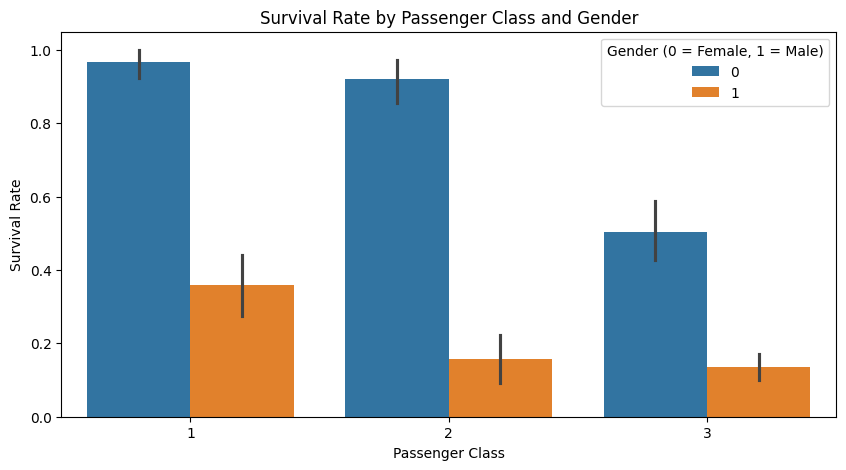

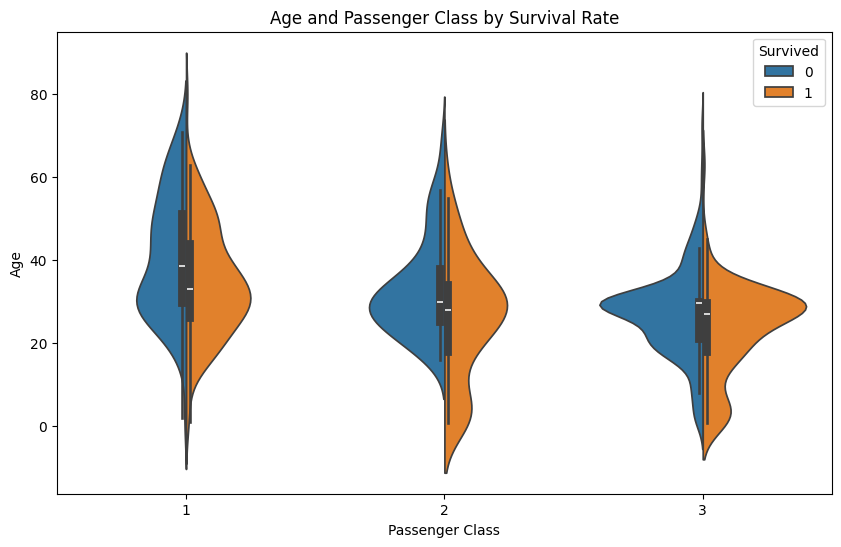

In [34]:
# 다중 변수 시각화: 성별과 객실 등급에 따른 생존율 시각화
plt.figure(figsize=(10, 5))
sns.barplot(x='Pclass', y='Survived', hue='Sex', data=train)
plt.title('Survival Rate by Passenger Class and Gender')
plt.xlabel('Passenger Class')
plt.ylabel('Survival Rate')
plt.legend(title='Gender (0 = Female, 1 = Male)')
plt.show()

# 나이와 객실 등급에 따른 생존율 시각화
plt.figure(figsize=(10, 6))
sns.violinplot(x='Pclass', y='Age', hue='Survived', split=True, data=train)
plt.title('Age and Passenger Class by Survival Rate')
plt.xlabel('Passenger Class')
plt.ylabel('Age')
plt.show()


### 다중 변수 분석 결과
1. **성별과 객실 등급 조합**: 1등석 여성의 생존율이 가장 높고, 3등석 남성의 생존율이 가장 낮습니다. 이는 성별과 사회적 계층이 생존 여부에 복합적으로 영향을 미쳤음을 시사합니다.
2. **나이와 객실 등급 조합**: 1등석의 어린 승객들은 높은 생존율을 보였으며, 3등석의 고령 승객들은 낮은 생존율을 보입니다.


## 3. 통계적 검정
- 변수와 생존 여부 간의 관계를 통계적으로 검증하여 유의미한 영향을 미치는지 확인합니다.


In [35]:
# 성별과 생존 여부에 대한 카이제곱 검정
sex_survived_crosstab = pd.crosstab(train['Sex'], train['Survived'])
chi2, p, _, _ = stats.chi2_contingency(sex_survived_crosstab)
print(f'카이제곱 검정 결과 (성별과 생존 여부): p-value = {p}')

# 객실 등급과 생존 여부에 대한 카이제곱 검정
pclass_survived_crosstab = pd.crosstab(train['Pclass'], train['Survived'])
chi2, p, _, _ = stats.chi2_contingency(pclass_survived_crosstab)
print(f'카이제곱 검정 결과 (객실 등급과 생존 여부): p-value = {p}')

# 나이와 생존 여부에 대한 t-검정
age_survived = train[train['Survived'] == 1]['Age'].dropna()
age_not_survived = train[train['Survived'] == 0]['Age'].dropna()
t_stat, p_value = stats.ttest_ind(age_survived, age_not_survived)
print(f't-검정 결과 (나이와 생존 여부): p-value = {p_value}')


카이제곱 검정 결과 (성별과 생존 여부): p-value = 2.452920518903667e-59
카이제곱 검정 결과 (객실 등급과 생존 여부): p-value = 2.3368519443890425e-22
t-검정 결과 (나이와 생존 여부): p-value = 0.03438636226786425


### 통계적 검정 결과
1. **성별과 생존 여부**: p-value가 유의수준 이하로 나타나 성별이 생존 여부에 유의미한 영향을 미친다는 점을 확인할 수 있습니다.
2. **객실 등급과 생존 여부**: 객실 등급 또한 생존 여부와 유의미한 관계가 있음이 확인되었습니다.
3. **나이와 생존 여부**: 나이와 생존 여부 간의 t-검정 결과, 어린 승객의 높은 생존율이 통계적으로 유의미함을 보여줍니다.


## 4. 머신러닝 모델링: 로지스틱 회귀 모델
- 로지스틱 회귀 모델을 사용하여 타이타닉 승객의 생존 여부를 예측합니다.


In [36]:
import statsmodels.api as sm
from sklearn.metrics import classification_report, confusion_matrix

# 로지스틱 회귀 모델에 종속변수 추가하여 학습
formula = "Survived ~ C(Pclass) + C(Sex) + scale(Age) + scale(SibSp) + scale(Parch) + scale(Fare) + C(Embarked_Q) + C(Embarked_S)"
model = sm.Logit.from_formula(formula, data=train)
result = model.fit()

# 예측 및 평가
y_pred = result.predict(val_x).apply(lambda x: 1 if x >= 0.5 else 0)
print(confusion_matrix(val_y, y_pred))
print(classification_report(val_y, y_pred))


Optimization terminated successfully.
         Current function value: 0.440767
         Iterations 6
[[83 20]
 [31 44]]
              precision    recall  f1-score   support

           0       0.73      0.81      0.76       103
           1       0.69      0.59      0.63        75

    accuracy                           0.71       178
   macro avg       0.71      0.70      0.70       178
weighted avg       0.71      0.71      0.71       178



### 로지스틱 회귀 모델 평가
- 성별, 객실 등급, 나이, 요금 등의 변수를 고려한 로지스틱 회귀 모델의 성능을 평가합니다.
- 모델은 성별과 계층을 고려한 변수들이 생존 여부 예측에 중요한 역할을 함을 보여줍니다.


## 5. 결론 및 인사이트 도출

1. **성별**: 여성의 생존율이 남성보다 유의미하게 높아, 당시 사회적 규범이 구조 우선순위에 영향을 미쳤음을 보여줍니다.
2. **객실 등급**: 1등석 승객의 생존율이 가장 높았으며, 이는 계층적 구조가 생존에 영향을 미쳤음을 시사합니다.
3. **나이**: 어린 승객들의 높은 생존율은 구조 시 나이에 따른 우선순위가 존재했음을 시사합니다.
4. **요금(Fare)**: 요금이 높을수록 생존율이 높은 경향은, 고액을 지불한 승객이 구조에 유리한 위치에 있었을 가능성을 나타냅니다.

### 최종 분석
타이타닉 사고에서 생존율에 영향을 미친 주요 요인은 성별, 객실 등급, 나이 등이며, 이를 통해 사회적, 경제적 구조와 구조 우선순위가 반영된 사회적 맥락을 이해할 수 있었습니다. 이 분석 및 모델링 과정은 단순한 예측을 넘어 데이터에 숨겨진 의미와 통찰을 발견하는 데 중점을 두었습니다.
